In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: big12gaurav
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:01<00:00, 377MB/s]


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available:",device)

Device available: cuda


In [3]:
image_path =[]
labels=[]

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df=pd.DataFrame(zip(image_path,labels),columns=["image_path","labels"])

print(data_df["labels"].unique())
data_df.head()

['dog' 'wild' 'cat']


,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [4]:
train=data_df.sample(frac=0.7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5)
test=test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [5]:
label_encoder=LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [6]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe=dataframe
    self.transform=transform
    self.labels=torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self,idx):
    img_path=self.dataframe.iloc[idx,0]
    label=self.labels[idx]

    image=Image.open(img_path).convert("RGB")

    if self.transform:
      image=self.transform(image).to(device)

      return image,label

In [7]:
train_dataset = CustomImageDataset(dataframe=train,transform=transform)
val_dataset = CustomImageDataset(dataframe=val,transform=transform)
test_dataset = CustomImageDataset(dataframe=test,transform=transform)

In [8]:
train_dataset.__getitem__(2)

(tensor([[[0.5137, 0.4196, 0.3647,  ..., 0.3843, 0.4039, 0.4000],
          [0.4980, 0.4627, 0.3922,  ..., 0.3882, 0.4118, 0.4039],
          [0.4510, 0.4549, 0.3843,  ..., 0.3686, 0.3804, 0.3804],
          ...,
          [0.6510, 0.5922, 0.5765,  ..., 0.3412, 0.3686, 0.3647],
          [0.7255, 0.7412, 0.7255,  ..., 0.3059, 0.3255, 0.3882],
          [0.6980, 0.7294, 0.7333,  ..., 0.3608, 0.3961, 0.4588]],
 
         [[0.6196, 0.3725, 0.3020,  ..., 0.3255, 0.3333, 0.3451],
          [0.6510, 0.4431, 0.3255,  ..., 0.3294, 0.3569, 0.3647],
          [0.6275, 0.4471, 0.3255,  ..., 0.3176, 0.3373, 0.3608],
          ...,
          [0.6902, 0.6314, 0.6118,  ..., 0.3059, 0.3529, 0.3608],
          [0.7686, 0.7843, 0.7686,  ..., 0.2706, 0.3059, 0.3843],
          [0.7451, 0.7765, 0.7804,  ..., 0.3412, 0.3647, 0.4314]],
 
         [[0.4196, 0.3020, 0.2588,  ..., 0.2667, 0.2980, 0.3137],
          [0.3922, 0.3255, 0.2667,  ..., 0.2667, 0.3137, 0.3294],
          [0.3529, 0.3176, 0.2549,  ...,

In [9]:
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

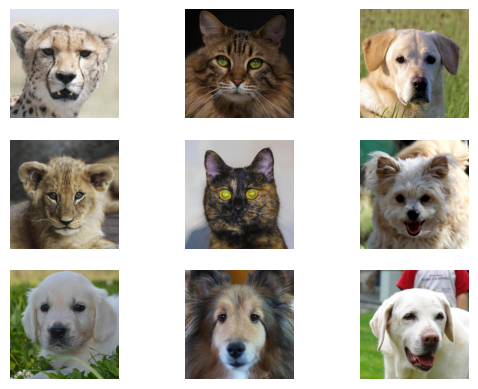

In [10]:
n_rows=3
n_cols=3

f,axarr=plt.subplots(n_rows,n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.show();

In [11]:
LR=1e-4
BATCH_SIZE=16
EPOCHS=10

In [12]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [13]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)

    self.pooling=nn.MaxPool2d(2,2)

    self.relu=nn.ReLU()

    self.flatten=nn.Flatten()
    self.linear=nn.Linear((128*16*16),128)

    self.output=nn.Linear(128,len(data_df['labels'].unique()))

  def forward(self,x):
    x=self.conv1(x) # ->(32,128,128)
    x=self.pooling(x) #-> (32,64,64)
    x=self.relu(x)

    x=self.conv2(x) # ->(64,64,64)
    x=self.pooling(x) #->(64,32,32)
    x=self.relu(x)

    x=self.conv3(x) #->(128,32,32)
    x=self.pooling(x) #->(128,16,16)
    x=self.relu(x)

    x=self.flatten(x)
    x=self.linear(x)
    x=self.output(x)
    return x

In [14]:
model=Net().to(device)

In [15]:
from torchsummary import summary
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=LR)

In [17]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

for epoch in range(EPOCHS):
  total_acc_train=0
  total_loss_train=0
  total_loss_val=0
  total_acc_val=0

  for inputs,labels in train_loader:
    optimizer.zero_grad()

    outputs=model(inputs)
    train_loss=criterion(outputs,labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()

    total_acc_train +=train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs ,labels in val_loader:
      outputs=model(inputs)
      val_loss=criterion(outputs,labels)
      total_loss_val+=val_loss.item()

      val_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
      total_acc_val+=val_acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
  total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))

  print(f'''Epoch {epoch+1}/{EPOCHS}  |  Train Loss:{round(total_loss_train/1000,4)}  |  Train Accuracy {round((total_acc_train/train_dataset.__len__())*100,4)}  |
        Validation Loss {round(total_loss_val/1000,4)}  |   Validation Accuracy {round((total_acc_val/val_dataset.__len__())*100,4)}''')


Epoch 1/10  |  Train Loss:0.3357  |  Train Accuracy 80.0106  |
        Validation Loss 0.0392  |   Validation Accuracy 90.4959
Epoch 2/10  |  Train Loss:0.149  |  Train Accuracy 92.3302  |
        Validation Loss 0.0258  |   Validation Accuracy 93.5537
Epoch 3/10  |  Train Loss:0.0978  |  Train Accuracy 95.1023  |
        Validation Loss 0.0188  |   Validation Accuracy 95.6198
Epoch 4/10  |  Train Loss:0.0661  |  Train Accuracy 96.5636  |
        Validation Loss 0.0166  |   Validation Accuracy 96.2397
Epoch 5/10  |  Train Loss:0.0487  |  Train Accuracy 97.591  |
        Validation Loss 0.0149  |   Validation Accuracy 96.4876
Epoch 6/10  |  Train Loss:0.0375  |  Train Accuracy 98.3172  |
        Validation Loss 0.0169  |   Validation Accuracy 96.1157
Epoch 7/10  |  Train Loss:0.0275  |  Train Accuracy 98.7069  |
        Validation Loss 0.015  |   Validation Accuracy 96.5702
Epoch 8/10  |  Train Loss:0.0195  |  Train Accuracy 99.0346  |
        Validation Loss 0.0161  |   Validation Accu

In [18]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0
  for inputs,labels in test_loader:
    predictions=model(inputs)

    acc=(torch.argmax(predictions,axis=1) == labels).sum().item()
    total_acc_test +=acc
    test_loss=criterion(predictions,labels)
    total_loss_test +=test_loss.item()

print(f"Accuracy Score is :{round((total_acc_test/test_dataset.__len__())*100,4)} and Loss is {round(total_loss_test/1000,4)}")

Accuracy Score is :96.4035 and Loss is 0.0189


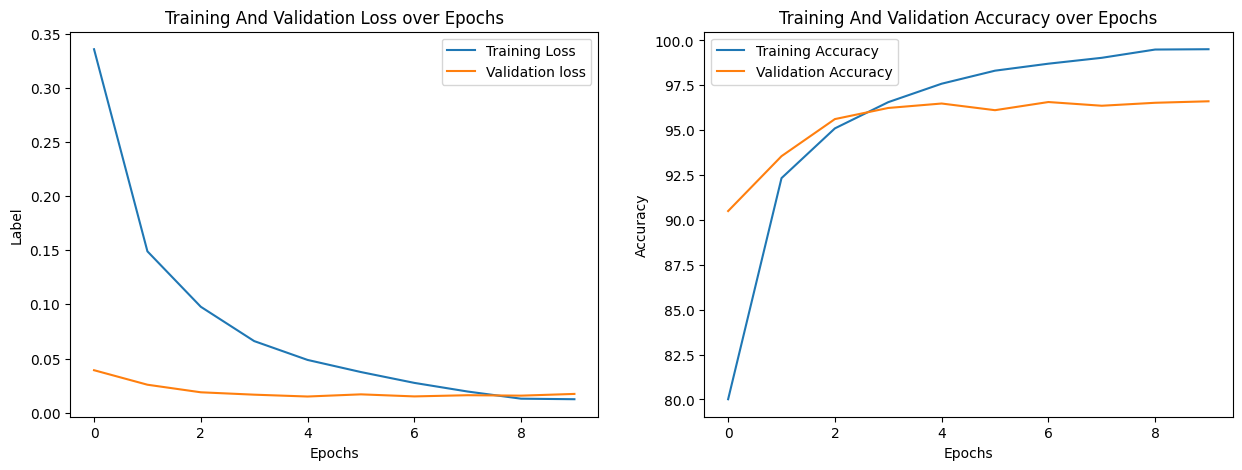

In [19]:
fig,axs = plt.subplots(nrows=1,ncols =2 ,figsize=(15,5))

axs[0].plot(total_loss_train_plot,label="Training Loss")
axs[0].plot(total_loss_validation_plot,label="Validation loss")
axs[0].set_title("Training And Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Label")
axs[0].legend()

axs[1].plot(total_acc_train_plot,label="Training Accuracy")
axs[1].plot(total_acc_validation_plot,label="Validation Accuracy")
axs[1].set_title("Training And Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [20]:
def predict_image(image_path):
  image=Image.open(image_path).convert("RGB")
  image=transform(image).to(device)
  output=model(image.unsqueeze(0))
  foutput=torch.argmax(output,axis=1).item()
  return label_encoder.inverse_transform([foutput])

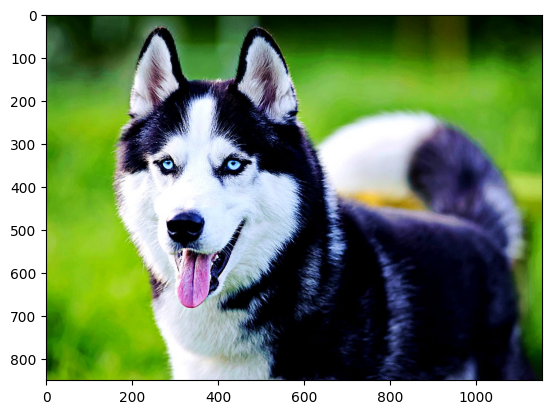

array(['dog'], dtype=object)

In [22]:
image=Image.open("/content/siberian-husky-107212.jpg")
plt.imshow(image)
plt.show()

predict_image("/content/siberian-husky-107212.jpg")

In [24]:
label_encoder.classes_

array(['cat', 'dog', 'wild'], dtype=object)

In [29]:
class_names=",".join(label_encoder.classes_)
print(class_names)

cat,dog,wild


In [33]:
with open("class_names.txt","w")as f:
  f.write(class_names)

In [31]:
torch.save(model.state_dict(),"model_state.pth")